# lab1

In [1]:
%%writefile lab/bitonic-sort.cpp
//==============================================================
// Copyright © 2020 Intel Corporation
//
// SPDX-License-Identifier: MIT
// =============================================================
//
// Bitonic Sort: this algorithm converts a randomized sequence of numbers into
// a bitonic sequence (two ordered sequences), and then merge these two ordered
// sequences into a ordered sequence. Bitonic sort algorithm is briefly
// described as followed:
//
// - First, it decomposes the randomized sequence of size 2**n into 2**(n-1)
// pairs where each pair consists of 2 consecutive elements. Note that each pair
// is a bitonic sequence.
// - Step 0: for each pair (sequence of size 2), the two elements are swapped so
// that the two consecutive pairs form  a bitonic sequence in increasing order,
// the next two pairs form the second bitonic sequence in decreasing order, the
// next two pairs form the third bitonic sequence in  increasing order, etc, ...
// . At the end of this step, we have 2**(n-1) bitonic sequences of size 2, and
// they follow an order increasing, decreasing, increasing, .., decreasing.
// Thus, they form 2**(n-2) bitonic sequences of size 4.
// - Step 1: for each new 2**(n-2) bitonic sequences of size 4, (each new
// sequence consists of 2 consecutive previous sequences), it swaps the elements
// so that at the end of step 1, we have 2**(n-2) bitonic sequences of size 4,
// and they follow an order: increasing, decreasing, increasing, ...,
// decreasing. Thus, they form 2**(n-3) bitonic sequences of size 8.
// - Same logic applies until we reach the last step.
// - Step n: at this last step, we have one bitonic sequence of size 2**n. The
// elements in the sequence are swapped until we have a sequence in increasing
// oder.
//
// In this implementation, a randomized sequence of size 2**n is given (n is a
// positive number). Unified Shared Memory (USM) is used for data management. At
// each stage, a part of step, the host redefines the ordered sequenes and sends
// data to the kernel. The kernel swaps the elements accordingly in parallel.
//
#include <math.h>
#include <iostream>
#include <string>
#include <optional>

// dpc_common.hpp can be found in the dev-utilities include folder.
// e.g., $ONEAPI_ROOT/dev-utilities/<version>/include/dpc_common.hpp
#include "dpc_common.hpp"

using namespace sycl;
using namespace std;

#define DEBUG 0

void ParallelBitonicSort(int data_gpu[], int n, queue &q) {
  // n: the exponent used to set the array size. Array size = power(2, n)
  int size = pow(2, n);
  int *a = data_gpu;

  std::optional<event> last_event;

  // step from 0, 1, 2, ...., n-1
  for (int step = 0; step < n; step++) {
    // for each step s, stage goes s, s-1, ..., 0
    for (int stage = step; stage >= 0; stage--) {
      int seq_len = pow(2, stage + 1);

      // Constant used in the kernel: 2**(step-stage).
      int two_power = 1 << (step - stage);

      // Offload the work to kernel.
      last_event = q.submit([&](auto &h) {
        if (last_event.has_value())
          h.depends_on(last_event.value());
        h.parallel_for(range<1>(size), [=](id<1> i) {
          // Assign the bitonic sequence number.
          int seq_num = i / seq_len;

          // Variable used to identified the swapped element.
          int swapped_ele = -1;

          // Because the elements in the first half in the bitonic
          // sequence may swap with elements in the second half,
          // only the first half of elements in each sequence is
          // required (seq_len/2).
          int h_len = seq_len / 2;

          if (i < (seq_len * seq_num) + h_len) swapped_ele = i + h_len;

          // Check whether increasing or decreasing order.
          int odd = seq_num / two_power;

          // Boolean variable used to determine "increasing" or
          // "decreasing" order.
          bool increasing = ((odd % 2) == 0);

          // Swap the elements in the bitonic sequence if needed
          if (swapped_ele != -1) {
            if (((a[i] > a[swapped_ele]) && increasing) ||
                ((a[i] < a[swapped_ele]) && !increasing)) {
              int temp = a[i];
              a[i] = a[swapped_ele];
              a[swapped_ele] = temp;
            }
          }
        });
      });
    }  // end stage
  }    // end step
  q.wait();
}

void ParallelBitonicSortBuffer(int data_gpu[], int n, queue &q) {
  // n: the exponent used to set the array size. Array size = power(2, n)
  int size = pow(2, n);

  buffer input(data_gpu, range(size));

  // step from 0, 1, 2, ...., n-1
  for (int step = 0; step < n; step++) {
    // for each step s, stage goes s, s-1, ..., 0
    for (int stage = step; stage >= 0; stage--) {
      int seq_len = pow(2, stage + 1);

      // Constant used in the kernel: 2**(step-stage).
      int two_power = 1 << (step - stage);

      // Offload the work to kernel.
      q.submit([&](auto &h) {
        accessor a(input, h);

        h.parallel_for(size, [=](id<1> i) {
          // Assign the bitonic sequence number.
          int seq_num = i / seq_len;

          // Variable used to identified the swapped element.
          int swapped_ele = -1;

          // Because the elements in the first half in the bitonic
          // sequence may swap with elements in the second half,
          // only the first half of elements in each sequence is
          // required (seq_len/2).
          int h_len = seq_len / 2;

          if (i < (seq_len * seq_num) + h_len) swapped_ele = i + h_len;

          // Check whether increasing or decreasing order.
          int odd = seq_num / two_power;

          // Boolean variable used to determine "increasing" or
          // "decreasing" order.
          bool increasing = ((odd % 2) == 0);

          // Swap the elements in the bitonic sequence if needed
          if (swapped_ele != -1) {
            if (((a[i] > a[swapped_ele]) && increasing) ||
                ((a[i] < a[swapped_ele]) && !increasing)) {
              int temp = a[i];
              a[i] = a[swapped_ele];
              a[swapped_ele] = temp;
            }
          }
        });
      });
    }  // end stage
  }    // end step
}

// Loop over the bitonic sequences at each stage in serial.
void SwapElements(int step, int stage, int num_sequence, int seq_len,
                  int *array) {
  for (int seq_num = 0; seq_num < num_sequence; seq_num++) {
    int odd = seq_num / (pow(2, (step - stage)));
    bool increasing = ((odd % 2) == 0);

    int h_len = seq_len / 2;

    // For all elements in a bitonic sequence, swap them if needed
    for (int i = seq_num * seq_len; i < seq_num * seq_len + h_len; i++) {
      int swapped_ele = i + h_len;

      if (((array[i] > array[swapped_ele]) && increasing) ||
          ((array[i] < array[swapped_ele]) && !increasing)) {
        int temp = array[i];
        array[i] = array[swapped_ele];
        array[swapped_ele] = temp;
      }
    }  // end for all elements in a sequence
  }    // end all sequences
}

// Function sorts an array in serial using bitonic sort algorithm. The size of
// the array is indicated by the exponent n: the array size is 2 ** n.
inline void BitonicSort(int a[], int n) {
  // n: the exponent indicating the array size = 2 ** n.

  // step from 0, 1, 2, ...., n-1
  for (int step = 0; step < n; step++) {
    // for each step s, stage goes s, s-1,..., 0
    for (int stage = step; stage >= 0; stage--) {
      // Sequences (same size) are formed at each stage.
      int num_sequence = pow(2, (n - stage - 1));
      // The length of the sequences (2, 4, ...).
      int sequence_len = pow(2, stage + 1);

      SwapElements(step, stage, num_sequence, sequence_len, a);
    }
  }
}

// Function showing the array.
void DisplayArray(int a[], int array_size) {
  for (int i = 0; i < array_size; ++i) cout << a[i] << " ";
  cout << "\n";
}

void Usage(string prog_name, int exponent) {
  cout << " Incorrect parameters\n";
  cout << " Usage: " << prog_name << " n k \n\n";
  cout << " n: Integer exponent presenting the size of the input array. "
          "The number of element in\n";
  cout << "    the array must be power of 2 (e.g., 1, 2, 4, ...). Please "
          "enter the corresponding\n";
  cout << "    exponent betwwen 0 and " << exponent - 1 << ".\n";
  cout << " k: Seed used to generate a random sequence.\n";
}

int main(int argc, char *argv[]) {
  int n, seed, size;
  int exp_max = log2(numeric_limits<int>::max());

  // Read parameters.
  try {
    n = stoi(argv[1]);

    // Verify the boundary of acceptance.
    if (n < 0 || n >= exp_max) {
      Usage(argv[0], exp_max);
      return -1;
    }

    seed = stoi(argv[2]);
    size = pow(2, n);
  } catch (...) {
    Usage(argv[0], exp_max);
    return -1;
  }

  cout << "\nArray size: " << size << ", seed: " << seed << "\n";

  // Create queue on implementation-chosen default device.
  queue q(cpu_selector{});
  //queue q(gpu_selector{});

  cout << "Device: " << q.get_device().get_info<info::device::name>() << "\n";

  // Memory allocated for host access only.
  int *data_cpu = (int *)malloc(size * sizeof(int));

  // USM allocation using malloc_shared: data stores a sequence of random
  // numbers.
  int *data_usm = malloc_shared<int>(size, q);

  // Memory allocated to store gpu results using buffer allocation
  int *data_gpu = (int *)malloc(size * sizeof(int));

  // Initialize the array randomly using a seed.
  srand(seed);

  for (int i = 0; i < size; i++)
    data_usm[i] = data_gpu[i] = data_cpu[i] = rand() % 1000;

#if DEBUG
  cout << "\ndata before:\n";
  DisplayArray(data_usm, size);
#endif

  // Start timer
  dpc_common::TimeInterval t_par1;

  // Parallel sort using buffer allocation
  ParallelBitonicSortBuffer(data_gpu, n, q);

  cout << "Kernel time using buffer allocation: " << t_par1.Elapsed()
       << " sec\n";

#if DEBUG
  cout << "\ndata_gpu after sorting using parallel bitonic sort:\n";
  DisplayArray(data_gpu, size);
#endif

  // Start timer
  dpc_common::TimeInterval t_par2;

  // Parallel sort using USM
  ParallelBitonicSort(data_usm, n, q);

  cout << "Kernel time using USM: " << t_par2.Elapsed() << " sec\n";

#if DEBUG
  cout << "\ndata_usm after sorting using parallel bitonic sort:\n";
  DisplayArray(data_usm, size);
#endif

  // Start timer
  dpc_common::TimeInterval t_ser;

  // Bitonic sort in CPU (serial)
  BitonicSort(data_cpu, n);

  cout << "CPU serial time: " << t_ser.Elapsed() << " sec\n";

  // Verify both bitonic sort algorithms in kernel and in CPU.
  bool pass = true;
  for (int i = 0; i < size - 1; i++) {
    // Validate the sequence order is increasing in both kernel and CPU.
    if ((data_usm[i] > data_usm[i + 1]) || (data_usm[i] != data_cpu[i])) {
      pass = false;
      break;
    }

    if ((data_gpu[i] > data_gpu[i + 1]) || (data_gpu[i] != data_cpu[i])) {
      pass = false;
      break;
    }
  }

  // Clean resources.
  free(data_cpu);
  free(data_usm, q);
  free(data_gpu);

  if (!pass) {
    cout << "\nFailed!\n";
    return -2;
  }

  cout << "\nSuccess!\n";
  return 0;
}

Overwriting lab/bitonic-sort.cpp


In [3]:
%%writefile compile_run.sh
#source /opt/intel/oneapi/setvars.sh
dpcpp -o bin/bitonic-sort lab/bitonic-sort.cpp
for i in {10..29}; do bin/bitonic-sort $i 42; done

Overwriting compile_run.sh


In [5]:
!qsub -l nodes=1:iris_xe_max:ppn=2 -d . compile_run.sh

1959995.v-qsvr-1.aidevcloud


In [ ]:
!qsub -l nodes=1:gen9:ppn=2 -d . compile_run.sh

1959440.v-qsvr-1.aidevcloud


In [4]:
!qsub -l nodes=1:gold6128:ppn=2 -d . compile_run.sh

1960003.v-qsvr-1.aidevcloud


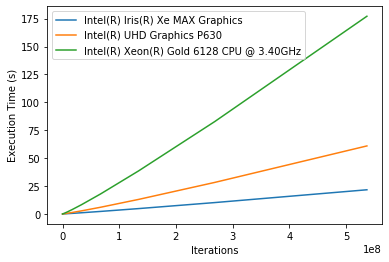

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

df = pd.read_csv("data.csv")
df = df.pivot(index='Size', columns='Arch', values='Time (s)')

plt.plot(df)
plt.legend(df, title='')
plt.ylabel("Execution Time (s)", rotation=90)
plt.xlabel("Iterations")
plt.show()

## References
- https://www.oneapi.io/
- https://www.geeksforgeeks.org/bitonic-sort/
- https://link.springer.com/book/10.1007/978-1-4842-5574-2
- https://ark.intel.com/content/www/us/en/ark/compare.html?productIds=120482,134860,211013